In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import scipy.stats as stats
# Giannoulis, this is a test

(429754, 9)
(429752, 9)


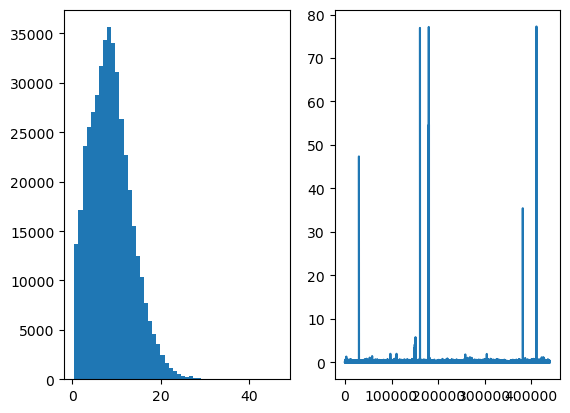

In [37]:
data_path = '../data/'
results_path = '../results/'

# load and print dataset
raw_data = pd.read_csv(data_path + 'HovsoreData_Sonic_100m_2004-2013.csv')
raw_data.head()

filt_idx = ((raw_data["Wsp"] > 60) | (raw_data["Wsp"] < 0.05)) | ((raw_data["TI"] < 0.01) | (raw_data["TI"] > 4))
filtered_data = raw_data[~filt_idx]
print(filtered_data.shape)
filtered_data = filtered_data.dropna(axis=0)
filtered_data = filtered_data.reset_index(drop=True)
print(filtered_data.shape)

# visualise dataset
# plt.plot(raw_data['Wsp'])
fig, ax = plt.subplots(1,2)
ax[0].hist(raw_data["Wsp"][raw_data["Wsp"] < 60], 50)
ax[1].plot(raw_data["TI"]) # outliers can be observed
# ax[0].hist(filtered_data["Wsp"], 50)
# ax[1].plot(filtered_data["TI"]) # outliers can be observed

plt.show()

# Fit joint distribution to wind speed, turbulence

In [38]:
# compute turbulence from sigmaU = TI * Wsp
filtered_data['sigmaWsp'] = filtered_data["TI"] * filtered_data["Wsp"]
filtered_data.head(3)

# fit weibull to wind speed : maximum likelihood method
Wsp0 = np.asarray(filtered_data["Wsp"])
# Wsp0 = Wsp0[Wsp0 < 60]
print(sum(np.isnan(Wsp0)))

mle_Weib = lambda theta : -np.sum(np.log( stats.weibull_min.pdf(Wsp0, loc=0, scale=theta[0], c=theta[1]) ))
Weibull_params = scipy.optimize.minimize(mle_Weib, [Wsp0.mean(), np.log(Wsp0).std()])
print(Weibull_params)
A_weibull = Weibull_params.x[0]
k_weibull = Weibull_params.x[1]

print("\nWeibull distribution:")
print(f"A:{A_weibull}")
print(f"k:{k_weibull}")

# fitted weibull distribution
Wsp_sort = np.sort(Wsp0)
pdf_weibull = stats.weibull_min.pdf(Wsp_sort, scale=A_weibull, c=k_weibull)

0
  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 1239279.5737238422
        x: [ 9.983e+00  2.033e+00]
      nit: 10
      jac: [ 0.000e+00  0.000e+00]
 hess_inv: [[ 1.294e-04  4.971e-05]
            [ 4.971e-05  2.598e-05]]
     nfev: 42
     njev: 14

Weibull distribution:
A:9.9834258809259
k:2.032556323671337


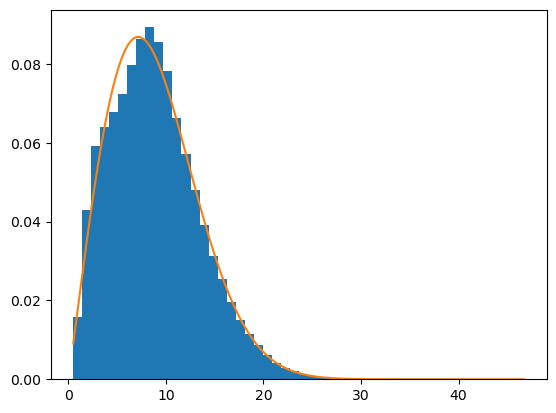

In [39]:
# Visualise fitted distribution
fig, ax = plt.subplots(1)
ax.hist(Wsp0, bins=50, density=True)
ax.plot(Wsp_sort, pdf_weibull)
plt.show()

In [41]:
# Fit conditional distribution to turbulence - bin data
WspBinEdges = np.arange(3.5, 32.5, 1)
WspBinCentres = .5 + WspBinEdges[:-1]

# initialise mean and std of turbulence for each bin
meanSigmaBinned = np.zeros_like(WspBinCentres)
stdSigmaBinned = np.zeros_like(WspBinCentres)

# find mean and std of turbulence (=sigmaU) in each bin
for i,val in enumerate(WspBinCentres):
    WspMask = (filtered_data["Wsp"] > WspBinEdges[i]) & (filtered_data["Wsp"] <= WspBinEdges[i+1])
    meanSigmaBinned[i] = np.mean( filtered_data.loc[WspMask, "sigmaWsp"] )
    stdSigmaBinned[i] = np.std( filtered_data.loc[WspMask, "sigmaWsp"] )
    
meanSigmaBinned = meanSigmaBinned[~np.isnan(meanSigmaBinned)]   
stdSigmaBinned = stdSigmaBinned[~np.isnan(meanSigmaBinned)]   
# print(len(WspBinEdges))
# print(enumerate(WspBinCentres))
# print(len(meanSigmaBinned))
# print(len(meanSigmaBinned))

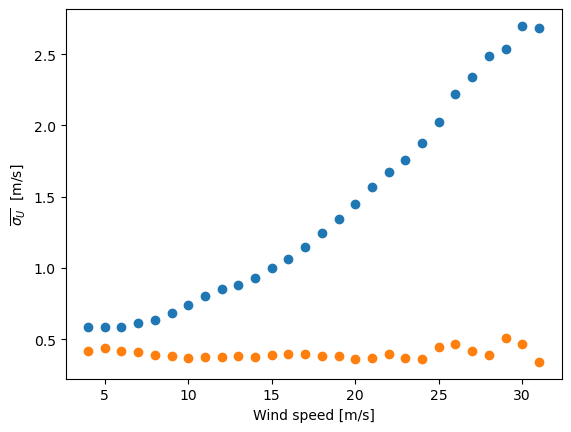

In [42]:
plt.scatter(WspBinCentres, meanSigmaBinned)
plt.scatter(WspBinCentres, stdSigmaBinned)
plt.xlabel("Wind speed [m/s]")
plt.ylabel(r"$\overline{\sigma_U}$  [m/s]")
plt.show()

In [47]:
pMu0 = np.polyfit(WspBinCentres, meanSigmaBinned,0)
pMu1 = np.polyfit(WspBinCentres, meanSigmaBinned,1)
pMu2 = np.polyfit(WspBinCentres, meanSigmaBinned,2)
pMsu0 = np.polyfit(WspBinCentres, stdSigmaBinned,0)

poly0 = np.poly1d(pMu0)
poly1 = np.poly1d(pMu1)
poly2 = np.poly1d(pMu2)
poly3 = np.poly1d(pMsu0)

SigmaSigmaRef = np.mean(stdSigmaBinned)
        
MuSigmaFunc = lambda u: poly2(u)
SigmaSigmaFunc = lambda u: SigmaSigmaRef * np.ones(u.shape)


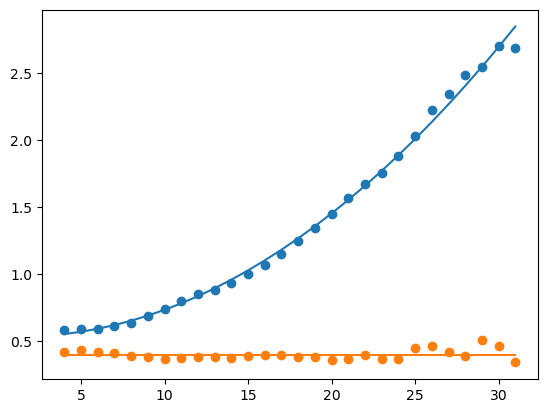

In [48]:
plt.scatter(WspBinCentres, meanSigmaBinned)
plt.scatter(WspBinCentres, stdSigmaBinned)
# plt.plot(WspBinCentres, poly0(WspBinCentres))
# plt.plot(WspBinCentres, poly1(WspBinCentres))
plt.plot(WspBinCentres, poly2(WspBinCentres))
plt.plot(WspBinCentres, poly3(WspBinCentres))
plt.show()

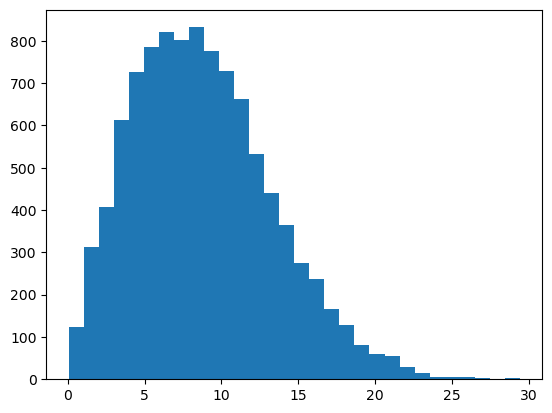

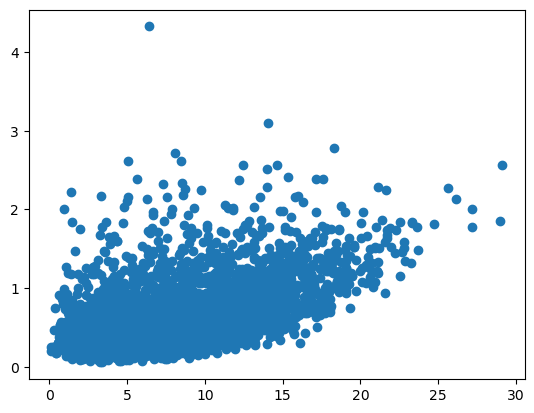

In [49]:
# Monte Carlo 
n = 10000

# Wind speed random sample
Urand = stats.weibull_min.ppf(np.random.randn(n), scale=A_weibull, c=k_weibull)
Urand = stats.weibull_min.rvs(scale=A_weibull, c=k_weibull, size=n)

# Turbulence random sample
def NormalDist(task,x,mu=0,sigma=1):
    import numpy as np
    if task == 0: # PDF
        y = (1.0/(sigma*np.sqrt(2.0*np.pi)))*np.exp(-((x - mu)**2)/(2.0*(sigma**2)))
    elif task == 1: # Cumulative
        from scipy.special import erf
        y = 0.5*(1.0 + erf((x - mu)/(sigma*np.sqrt(2))))
    elif task == 2: # Inverse
        from scipy.special import erfinv
        y = mu + sigma*np.sqrt(2)*erfinv(2*x - 1)        
    return y
# Helper function - lognormal distribution
def LogNormDist(task,x,mu,sigma):
    import numpy as np
    tol = 1e-16
    mu = np.asarray(mu)
    mu[mu<tol] = tol
    Eps   = np.sqrt(np.log( 1.0+(sigma/mu)**2 ) )
    Ksi   = np.log(mu)-0.5*Eps**2
    if task == 0: # PDF
        x[x<=0] = 1e-8
        u =(np.log(x)-Ksi)/Eps
        y = np.exp(-u*u/2.0)/(Eps*x*np.sqrt(2.0*np.pi))
    elif task == 1: # Cummulative
        x[x<=0] = 1e-8
        u =(np.log(x)-Ksi)/Eps
        y= NormalDist(1, u)
    elif task == 2: # Inverse
        y= np.exp(Ksi+Eps*NormalDist(2, x))
    
    return y

MuSigmaU = MuSigmaFunc(Urand)
SigmaSigmaU = SigmaSigmaFunc(Urand)
SigmaUrand = LogNormDist(2, np.random.randn(n), mu=MuSigmaU, sigma=SigmaSigmaU)
# SigmaSigmaUrand = stats.lognorm.ppf(np.random.randn(n), s=SigmaSigmaU)

plt.hist(Urand, 30)
plt.show()
plt.scatter(Urand, SigmaUrand)
plt.show()

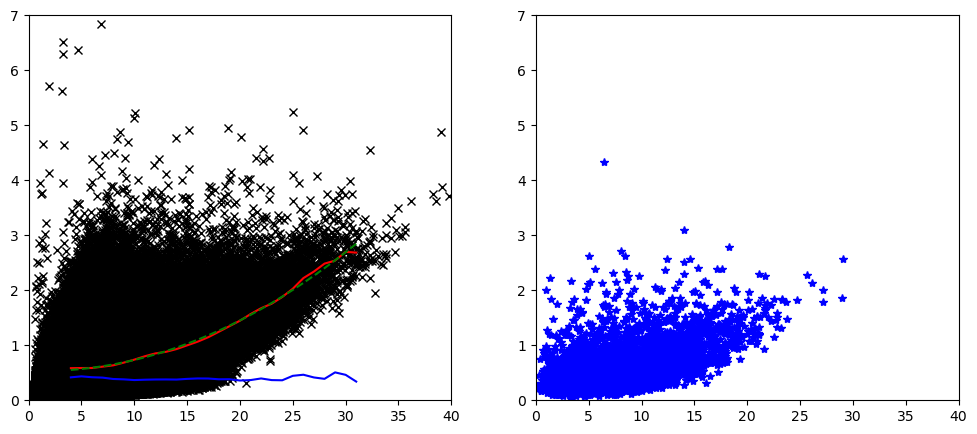

In [51]:
fig,ax = plt.subplots(1,2, figsize = (12,5))
ax[0].plot(filtered_data['Wsp'],filtered_data['sigmaWsp'],'xk')
ax[0].plot(WspBinCentres,meanSigmaBinned,'-r')
ax[0].plot(WspBinCentres,stdSigmaBinned,'-b')
ax[0].plot(WspBinCentres,MuSigmaFunc(WspBinCentres),'--g')
ax[0].set_xlim([0,40])
ax[0].set_ylim([0,7])
ax[1].plot(Urand,SigmaUrand,'*b')
ax[1].set_xlim([0,40])
ax[1].set_ylim([0,7])
plt.show()

# Task 2